# Mapping crimes in Del Rey/Pacific Division

In [ ]:
# https://github.com/dnanhkhoa/nb_black
%load_ext lab_black

### Import data tools

In [2]:
import pandas as pd
import geopandas as gpd
import pyarrow
import matplotlib
import matplotlib.pyplot as plt
import geojson
import json
import fiona
import jenkspy
import numpy as np
from earthpy import clip as cl
from altair import datum
import altair as alt
import altair_latimes as lat

alt.themes.register("latimes", lat.theme)
alt.themes.enable("latimes")
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000

### Run if most-recent data is needed

In [3]:
# %run '00-lapd-crimes-processing.ipynb'

### Read crimes CSV downloaded from LA City data portal

In [4]:
crimes = pd.read_csv(
    "/Users/mhustiles/data/data/LA/crimes.csv",
    dtype={
        "area_name": str,
        "rpt_dist_no": str,
        "weapon_used_cd": str,
        "crm_cd": str,
        "premises_code": str,
        "division": str,
    },
)

In [5]:
crimes.drop(
    [
        "crime_code",
        "victim_descent",
        "division",
        "part_type",
        "crime_code",
        "weapon_code",
        "status_code",
        "crm_cd_1",
        "crm_cd_2",
        "crm_cd_3",
        "crm_cd_4",
        "cross_street",
        "part_category",
        "premises_code",
    ],
    axis=1,
    inplace=True,
)

### How many Part 1 crimes? 

In [6]:
len(crimes)

848719

### Isolate just crimes in the Pacific Division, which contains Del Rey

In [7]:
delrey_crimes = crimes[crimes["division_name"] == "Pacific"]

### How many Part 1 crimes are looking at now? 

In [8]:
len(delrey_crimes)

49778

---

## Import mapping data

In [9]:
# Transform our crimes data into a geoDataFrame
delrey_crimes_geo = gpd.GeoDataFrame(
    delrey_crimes,
    geometry=gpd.points_from_xy(delrey_crimes.longitude, delrey_crimes.latitude),
)

### Set the geographic file's coordinate reference system

In [10]:
delrey_crimes_geo = delrey_crimes_geo.set_crs("EPSG:4326")
delrey_crimes_geo = delrey_crimes_geo.set_crs(epsg=4326)

### Read LAPD reporting districts

In [11]:
districts = gpd.read_file("input/LAPD_Reporting_Districts/LAPD_Reporting_Districts.shp")

### Read LAPD divisions

In [12]:
divisions = gpd.read_file("input/LAPD_Divisions/LAPD_Divisions.shp")

### Read LA Times neighborhoods

In [13]:
hoods = gpd.read_file("input/custom-la-hoods-skid-row.geojson")

---

## Isolate just Del Rey crimes

### First, get the neighborhood boundary

In [14]:
del_rey = hoods[hoods["name"] == "Del Rey"]

### Next, get only those crimes within the boundaries by performing a spatial merge

In [15]:
dr_crimes = gpd.sjoin(delrey_crimes_geo, del_rey, how="inner", op="within")

### Did it work? 

<AxesSubplot:>

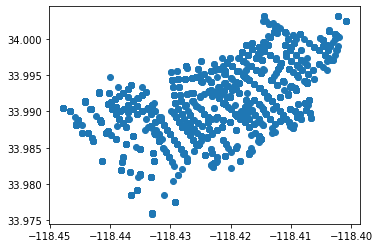

In [16]:
dr_crimes.plot()

### How many crimes now? 

In [17]:
len(dr_crimes)

4575

---

## Basic aggregates on variables for all crimes

### Which crimes are most common? 

In [18]:
violations = (
    dr_crimes.groupby(["crime_code_description"])
    .agg("size")
    .reset_index(name="total")
    .sort_values(by="total", ascending=False)
)

In [19]:
violations.head(10)

,crime_code_description,total
7,Burglary,864
34,Theft plain - petty ($950 & under),773
39,Vehicle - stolen,545
8,Burglary from vehicle,517
36,"Theft-grand ($950.01 & over)excpt,guns,fowl,li...",405
31,Theft from motor vehicle - petty ($950 & under),344
2,"Assault with deadly weapon, aggravated assault",299
30,Theft from motor vehicle - grand ($400 and over),214
21,Robbery,156
4,Bike - stolen,75


### Places where crimes occur?

In [20]:
places = (
    dr_crimes.groupby(["premises_description"])
    .agg("size")
    .reset_index(name="total")
    .sort_values(by="total", ascending=False)
)

In [21]:
places.head(5)

,premises_description,total
61,Street,1104
59,Single family dwelling,754
37,"Multi-unit dwelling (apartment, duplex, etc)",437
45,Parking lot,431
23,Garage/carport,387


### Aggregates for police geography

In [26]:
divisions = (
    dr_crimes.groupby(["crime_code_description", "year"])
    .agg("size")
    .reset_index(name="total")
    .sort_values(by="total", ascending=False)
)

In [27]:
divisions.head()

,crime_code_description,year,total
40,Burglary,2014,147
165,Theft plain - petty ($950 & under),2014,139
38,Burglary,2012,133
164,Theft plain - petty ($950 & under),2013,130
41,Burglary,2015,123


In [24]:
districts = (
    dr_crimes.groupby(
        ["reporting_district", "division_name", "crime_code_description", "year"]
    )
    .agg("size")
    .reset_index(name="total")
    .sort_values(by="total", ascending=False)
)

In [25]:
districts.head()

In [35]:
divisions

,crime_code_description,year,total
40,Burglary,2014,147
165,Theft plain - petty ($950 & under),2014,139
38,Burglary,2012,133
164,Theft plain - petty ($950 & under),2013,130
41,Burglary,2015,123
166,Theft plain - petty ($950 & under),2015,107
39,Burglary,2013,107
202,Vehicle - stolen,2020,105
163,Theft plain - petty ($950 & under),2012,99
178,"Theft-grand ($950.01 & over)excpt,guns,fowl,li...",2010,98


---

In [37]:
alt.Chart(divisions).mark_bar().encode(
    y=alt.Y(
        "total:Q",
        title="Arrests",
        axis=alt.Axis(format="", tickCount=6),
        sort=alt.EncodingSortField(
            field="year",  # The field to use for the sort
            order="ascending",  # The order to sort in
        ),
    ),
    x=alt.X("year:N", axis=alt.Axis(format="", title="Year")),
    facet=alt.Facet("crime_code_description:N", columns=2),
).properties(width=350, height=250)

alt.Chart(...)